In [2]:
import sys
sys.path.insert(0,'..')

In [3]:
import cv2
import timm
import torch
import random
import numpy as np
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from typing import List, Dict
import matplotlib.pyplot as plt
from src.io.io import load_config
from src.dataset import SSLSTL10
from src.transform import ValTransform
from torch.utils.data import DataLoader
from src.model.vit import compute_attentions
from src.model.utils import create_model, load_state_dict_ssl

/Users/riccardomusmeci/Developer/github/lightning-ssl/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Checkpoints + Config**

In [4]:
ckpt_path = "/Users/riccardomusmeci/Developer/experiments/lightning-ssl/dino-vit-tiny-sagemaker-stl10-96/checkpoints/epoch=282-step=442046-val_loss=3.186.ckpt"
config_path = "/Users/riccardomusmeci/Developer/experiments/lightning-ssl/dino-vit-tiny-sagemaker-stl10-96/dino.yml"

### **Loading Model**

In [5]:
config = load_config(path=config_path)
config["model"]

{'backbone': 'custom_vit_tiny_patch16',
 'pretrained': True,
 'hidden_dim': 4096,
 'proj_dim': 256,
 'out_dim': 65568,
 'num_layers': 3,
 'use_bn': False,
 'use_gelu': True,
 'drop_p': 0,
 'init_weights': False,
 'norm_last_layer': True,
 'beta': 0.996}

In [6]:
BACKBONE = config["model"]["backbone"]
IMG_SIZE = config["transform"]["img_size"]

In [7]:
model = create_model(
    backbone=BACKBONE,
    pretrained=False,
    img_size=IMG_SIZE
)

In [8]:
model = load_state_dict_ssl(
    model=model,
    ssl_state_dict=torch.load(ckpt_path, map_location="cpu")["state_dict"]
)

> Loaded weights into model for 138/138 layers.


### **Setting up SSLTransform + ODIN Dataset**

In [9]:
transform = ValTransform(
    model="dino",
    **config["transform"]
)
dataset = SSLSTL10(
    root="/Users/riccardomusmeci/Developer/data/stl10",
    train=False,
    transform=transform
)

In [70]:
i = random.randint(a=0, b=len(dataset)-1)
img_path = dataset.img_paths[i]
label = dataset.labels[i]
    
img = Image.open(img_path)
img = img.resize((IMG_SIZE, IMG_SIZE))

# Augmentation
x, views = transform(img=img)

# Input Tensor
x = torch.from_numpy(x).unsqueeze(dim=0)

print(f"dataset index {i} - path: {dataset.img_paths[i]} - label {label}")

dataset index 2266 - path: /Users/riccardomusmeci/Developer/data/stl10/test/6/1373_6.png - label dog


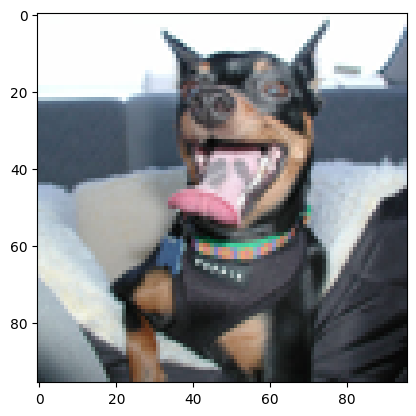

In [71]:
plt.imshow(img)

### **Attentions**

In [72]:
attentions = compute_attentions(
    model=model,
    x=x, 
    patch_size=16
)

Preparing images to show

In [73]:
np_img = np.array(img)
mask = np.sum(attentions, axis=0)
mask = cv2.blur(mask,(10,10))
mask = np.stack([mask, mask, mask], axis=-1)
mask = mask / mask.max()
result = (mask * img).astype("uint8")

(-0.5, 95.5, 95.5, -0.5)

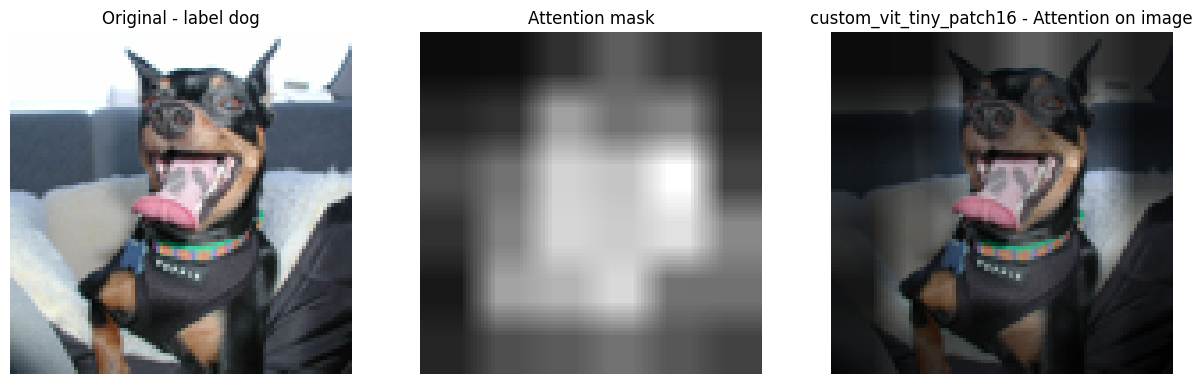

In [74]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)

ax[0].imshow(img)
ax[0].set_title(f"Original - label {label}")
ax[0].axis("off")

ax[1].imshow(mask)
ax[1].set_title("Attention mask")
ax[1].axis("off")

ax[2].imshow(result)
ax[2].set_title(f"{BACKBONE} - Attention on image")
ax[2].axis("off")